In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as pyPlot
import pandas.io.sql as psql
import psycopg2 as pg
import numpy as np
from matplotlib.font_manager import FontProperties

/Users/ca/PycharmProjects/JupyterNoteBookExample/venv/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [4]:
with pg.connect(database='chi-navi-mesh',
                host='localhost',
                user='postgres',
                port=5432) as conn:
    all_season_sql = "with delay_info as( " \
                     "with route_bus_stop_list as( " \
                     "select " \
                     "t.task_id,r.route_id,b.bus_stop_id,rbs.ordinal " \
                     "from " \
                     "bus_stop b,route r,route_bus_stop rbs,task t " \
                     "where " \
                     "b.bus_stop_id = rbs.bus_stop_id " \
                     "and r.route_id = rbs.route_id " \
                     "and t.route_id = r.route_id " \
                     "order by r.route_id,rbs.ordinal " \
                     "), " \
                     "delay_list as( " \
                     "with stddev as( " \
                     "select " \
                     "stddev_samp(extract(epoch from (collide_at - departure_time))) as stddev " \
                     "from " \
                     "task_delay " \
                     "where " \
                     "(collide_at - departure_time) > '00:00:00' " \
                     "), " \
                     "delay_avg as( " \
                     "select " \
                     "avg((extract(epoch from (collide_at - departure_time)))) as delay_avg " \
                     "from " \
                     "task_delay " \
                     "where " \
                     "(collide_at - departure_time) > '00:00:00' " \
                     ") " \
                     "select " \
                     "td.task_id,td.departure_time,td.bus_stop_id,td.submit_in,td.collide_at " \
                     ",extract(epoch from (td.collide_at - td2.departure_time)) as delay " \
                     "from " \
                     "task_delay td,delay_avg da,stddev std,task_detail td2 " \
                     "where " \
                     "(extract(epoch from (td.collide_at - td2.departure_time)) between " \
                     "da.delay_avg - std.stddev * 3 and da.delay_avg + std.stddev * 3) " \
                     "and extract(epoch from (td.collide_at - td2.departure_time)) > 0 " \
                     "and td.task_id = td2.task_id " \
                     "and td.bus_stop_id = td2.bus_stop_id " \
                     "and td.departure_time = td2.departure_time " \
                     ") " \
                     "select " \
                     "distinct r.route_id,r.bus_stop_id,r.ordinal,d.collide_at, " \
                     "d.task_id,d.delay,d.submit_in,d.departure_time,date_part('HOUR' , d.departure_time) as time " \
                     "from " \
                     "delay_list d, route_bus_stop_list r " \
                     "where " \
                     "d.bus_stop_id = r.bus_stop_id " \
                     "and r.task_id = d.task_id " \
                     "), " \
                     "access_info as( " \
                     "select " \
                     "count(distinct session_id) as access_num,browsing_at::date as date," \
                     "date_part('HOUR' , browsing_at) as time, " \
                     "case when " \
                     "extract(dow from browsing_at::date) = 0 or extract(dow from browsing_at::date) = 6 then 0 " \
                     "else 1 " \
                     "end as youbi " \
                     "from " \
                     "user_browsing_log ubl " \
                     "group by date,time " \
                     ") " \
                     "select " \
                     "case " \
                     "when delay between 0 and 60 then 1 " \
                     "when delay between 61 and 120 then 2 " \
                     "when delay between 121 and 180 then 3 " \
                     "when delay between 181 and 240 then 4 " \
                     "when delay between 241 and 300 then 5 " \
                     "when delay between 301 and 360 then 6 " \
                     "when delay between 361 and 420 then 7 " \
                     "when delay between 421 and 480 then 8 " \
                     "when delay between 481 and 540 then 9 " \
                     "when delay > 540 then 10 " \
                     "end as delay, " \
                     "di.bus_stop_id," \
                     "ai.time, " \
                     "ai.access_num,ai.youbi, " \
                     "case " \
                     "when submit_in = '2017-07-23' then 1/* 航空祭 */ " \
                     "when (submit_in between '2018-01-26' and '2018-02-18') or " \
                     "(submit_in between '2017-01-27' and '2017-02-19') " \
                     "then 2/* ひょうとう祭り */ " \
                     "when submit_in between '2017-07-06' and '2017-07-09' then 3/* セガサミーカップ */ " \
                     "else 0 " \
                     "end as event, " \
                     "case " \
                     "when " \
                     "di.route_id in (13,14,23,24,55,56,58,59,60,61,62,63,64,67,68,69,70,71,74" \
                     ",78,79,80,81,82,91,92,93,94,95,96,97,98,99,106,107,108,109,11) then 1 " \
                     "else 0 " \
                     "end as destination " \
                     "from " \
                     "delay_info di,access_info ai " \
                     "where " \
                     "di.time = ai.time " \
                     "and di.submit_in = ai.date"


In [5]:
sql_result = psql.read_sql(all_season_sql, conn)

32.8949404301408
23.45659910258394
18.072102738666253
12.177007581618444
6.684202382794369
3.5123007891072255
2.135231316725979
0.6343803187374285
0.23209036051369333
0.20114497911186754


<BarContainer object of 10 artists>

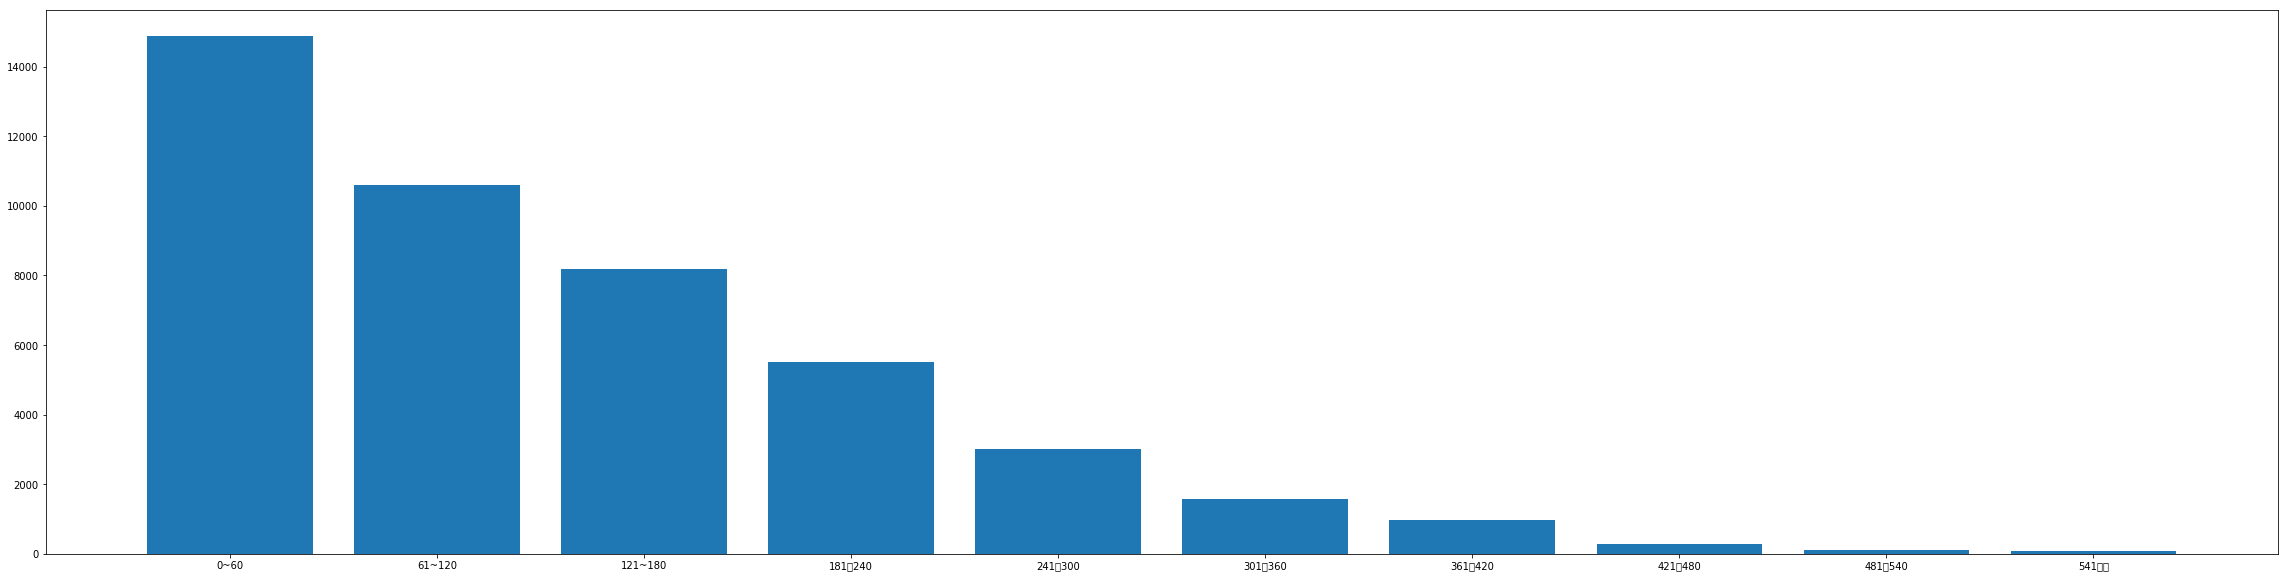

In [6]:
font_path = './ipaexg.ttf'
font_prop = FontProperties(fname=font_path)
pyPlot.figure(figsize=(40, 10))
left = ['0~60', '61~120', '121~180', '181〜240', '241〜300', '301〜360', '361〜420', '421〜480', '481〜540', '541以上']

sql_result = sql_result[sql_result['bus_stop_id'] == 183]

delay_one = sql_result[sql_result['delay'] == 1].size
delay_two = sql_result[sql_result['delay'] == 2].size
delay_three = sql_result[sql_result['delay'] == 3].size
delay_four = sql_result[sql_result['delay'] == 4].size
delay_five = sql_result[sql_result['delay'] == 5].size
delay_six = sql_result[sql_result['delay'] == 6].size
delay_seven = sql_result[sql_result['delay'] == 7].size
delay_eight = sql_result[sql_result['delay'] == 8].size
delay_nine = sql_result[sql_result['delay'] == 9].size
delay_ten = sql_result[sql_result['delay'] == 10].size

print(delay_one / sql_result.size * 100)
print(delay_two / sql_result.size * 100)
print(delay_three / sql_result.size * 100)
print(delay_four / sql_result.size * 100)
print(delay_five / sql_result.size * 100)
print(delay_six / sql_result.size * 100)
print(delay_seven / sql_result.size * 100)
print(delay_eight / sql_result.size * 100)
print(delay_nine / sql_result.size * 100)
print(delay_ten / sql_result.size * 100)

height = np.array([delay_one, delay_two, delay_three, delay_four, delay_five, 
                   delay_six, delay_seven, delay_eight, delay_nine, delay_ten])
pyPlot.bar(left, height)